In [32]:
import os
os.environ['DEBUG'] = '0'
import cv2
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

In [99]:
import importlib
import models.layers.z_buffer_layers
importlib.reload(models.layers.z_buffer_layers)
import models.projection.z_buffer_manipulator
importlib.reload(models.projection.z_buffer_manipulator)
from models.projection.z_buffer_manipulator import EquiPtsManipulator

In [ ]:
def transfer_xyz_equi(depth):
        batch_size = depth.size()[0]
        equ_w = depth.size()[3]
        equ_h = depth.size()[2]
        cen_x = (equ_w - 1) / 2.0
        cen_y = (equ_h - 1) / 2.0
        theta = (2 * (torch.arange(equ_w) - cen_x) / equ_w) * PI
        phi = (2 * (torch.arange(equ_h) - cen_y) / equ_h) * (PI / 2)
        theta = theta[None, :].repeat(equ_h, 1)
        phi = phi[None, :].repeat(equ_w, 1).T

        x = (torch.cos(phi) * torch.sin(theta)).unsqueeze(0).unsqueeze(0)
        y = (torch.sin(phi)).unsqueeze(0).unsqueeze(0)
        z = (torch.cos(phi) * torch.cos(theta)).unsqueeze(0).unsqueeze(0)
        xyz = torch.cat([x, y, z], 1).repeat(batch_size, 1, 1, 1).permute(0, 2, 3, 1)
        # xyz: batch x H x W x 3

        return xyz

In [6]:
input_path = './demos/hallway.jpg'
inputs = Image.open(input_path).convert("RGB")
inputs = np.array(inputs, np.float32) / 255
inputs = cv2.resize(inputs, (512, 256), interpolation=cv2.INTER_NEAREST)
inputs = transforms.ToTensor()(inputs).unsqueeze(0) # batch x 3 x H x W
inputs.shape

torch.Size([1, 3, 256, 512])

In [100]:
MODEL_PATH = './modelcheckpoints/realestate/zbufferpts.pth'
opts = torch.load(MODEL_PATH)['opts']
opts.render_ids = [1]
opts.radius = 2
print(opts.radius)

input_path = './demos/hallway.jpg'
inputs = Image.open(input_path).convert("RGB")
inputs = np.array(inputs, np.float32) / 255
inputs = cv2.resize(inputs, (512, 256), interpolation=cv2.INTER_NEAREST)
inputs = transforms.ToTensor()(inputs).unsqueeze(0).to('cuda') # batch x 3 x H x W
regressed_pts = torch.ones((1, 1, 256, 512)).to('cuda')
transformer = EquiPtsManipulator(256, 512, 3, opts).to('cuda')

K = torch.eye(4).unsqueeze(0).to('cuda')
K_inv = torch.eye(4).unsqueeze(0).to('cuda')
input_RT = torch.eye(4).unsqueeze(0).to('cuda')
input_RTinv = torch.eye(4).unsqueeze(0).to('cuda')
output_RT = torch.eye(4).unsqueeze(0).to('cuda')
output_RTinv = torch.eye(4).unsqueeze(0).to('cuda')

outputs = transformer.forward_justpts(
            inputs,
            regressed_pts,
            K,
            K_inv,
            input_RT,
            input_RTinv,
            output_RT,
            output_RTinv,
        )
outputs.shape

2
Max dist:  tensor(6.1035e-05, device='cuda:0') 6.103515625e-05
Max dist:  tensor(1.0000, device='cuda:0')


torch.Size([1, 3, 256, 512])

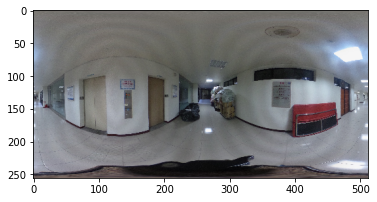

In [101]:
out = outputs.squeeze(0).cpu().numpy().transpose((1, 2, 0))
plt.imshow(out)

In [66]:
isinstance((1, 2), float)

False